# 1A. Importing dependencies

In [200]:
import mesa
import numpy as np
import matplotlib.pyplot as plt
import math
import networkx as nx

%matplotlib inline

# 1B. Helper Functions

In [201]:
def get_distance(pos_1, pos_2):
    '''
    Getting the euclidian distance by using the pytaghorean theorem

    used in trade.move()
    '''

    x1, x2, = pos_1
    y1, y2 = pos_2

    dx = x1 - x2
    dy = y1 - y2

    return math.sqrt(dx**2 + dy**2)

def flatten(list_of_lists):
    '''
    helper function for model datacollector for trade price
    collapses agent price list into one list
    '''
    return [item for sublist in list_of_lists for item in sublist]

def geometric_mean(list_of_prices):
    '''
    Find the geometric mean from the list of prices
    '''
    return np.exp(np.log(list_of_prices).mean())

def get_trade(agent):
    '''
    Filters agents to return only trade_partners
    Helper function of datacolletor for agent trade network
    '''
    if type(agent) == Trader:
        return agent.trade_partners
    else:
        return None

# 2. Resource Classes

In [202]:
class Sugar(mesa.Agent):
    '''
    Sugar:
    - Contains an amount of sugar
    - Grows one amount of sugar at each turn
    '''

    def __init__(self, unique_id, model, pos, max_sugar):
        super().__init__(unique_id, model)
        self.pos = pos
        self.amount = max_sugar
        self.max_sugar = max_sugar

    def step(self):
        '''
        Sugar Growth function:
        Adds one unit of sugar each step until max_sugar is met
        '''
        self.amount = min([self.max_sugar, self.amount+1])

In [203]:
class Spice(mesa.Agent):
    '''
    Spice:
    - Contains an amount of spice
    - Grows one amnount of spice at each turn
    '''

    def __init__(self, unique_id, model, pos, max_spice):
        super().__init__(unique_id, model)
        self.pos = pos
        self.amount = max_spice
        self.max_spice = max_spice

    def step(self):
        '''
        Spice growth function:
        Adds one unit of spice each step until max_spice is met
        '''
        self.amount = min([self.max_spice, self.amount+1])

# 3. Trader Class

In [204]:
class Trader(mesa.Agent):
    '''
    Trader:
    - Has a metabolism for sugar and spice
    - Harvests and trade sugar and spice to survive and thrive
    '''

    def __init__(self, unique_id, model, pos, moore=False, sugar=0,
                 spice=0,metabolism_sugar=0,metabolism_spice=0,
                 vision=0):

        super().__init__(unique_id,model)
        self.pos = pos
        self.moore = moore
        self.sugar = sugar
        self.spice = spice
        self.metabolism_sugar = metabolism_sugar
        self.metabolism_spice = metabolism_spice
        self.vision = vision
        self.prices = []
        self.trade_partners = []

    ################################
    ### RESOURCE CHECK FUNCTIONS ###
    ################################

    def get_sugar(self, pos):
        this_cell = self.model.grid.get_cell_list_contents(pos)
        for agent in this_cell:
            if type(agent) is Sugar:
                return agent
        return None

    def get_sugar_amount(self, pos):
        '''
        Helper function of calculate_welfare()
        Get sugar amount of cells around agent
        '''
        sugar_patch = self.get_sugar(pos)
        if sugar_patch:
            return sugar_patch.amount
        return 0
    
    def get_spice(self, pos):
        this_cell = self.model.grid.get_cell_list_contents(pos)
        for agent in this_cell:
            if type(agent) is Spice:
                return agent
        return None
    
    def get_spice_amount(self, pos):
        '''
        Helpter function of calculate_welfare()
        Get spice amount of cells around agent
        '''
        spice_patch = self.get_spice(pos)
        if spice_patch:
            return spice_patch.amount
        return 0

    ##############################
    ### TRADER CHECK FUNCTIONS ###
    ##############################

    def get_trader(self, pos):
        '''
        Helper function of self.trade_with_neighbors()


        '''
        this_cell = self.model.grid.get_cell_list_contents(pos)

        for agent in this_cell:
            if isinstance(agent, Trader):
                return agent


    def is_occupied_by_other(self, pos):
        '''
        Helper function part of self.move
        Check if a cell is occupied
        '''
        if pos == self.pos:
            # agent position is considered unoccupied as agent can stay there
            return False
        this_cell = self.model.grid.get_cell_list_contents(pos)
        for a in this_cell:
            # see if occupied by another agent
            if isinstance(a, Trader):
                return True
        return False
    

    ##################################
    ### TRADER BEHAVIOUR FUNCTIONS ###
    ##################################

    def calculate_welfare(self, sugar, spice):
        '''
        Helper function of self.move

        '''
        # Calculate total resources that the agent has
        m_total =  self.metabolism_sugar + self.metabolism_spice

        # Cobb douglas function:
        ## https://inomics.com/terms/cobb-douglas-production-function-1456726

        return sugar**(self.metabolism_sugar/m_total) * spice**(self.metabolism_spice/m_total)
    
    def is_starved(self):
        '''
        Helper function for maybe_die()
        '''
        # This returns True:
        return (self.sugar <= 0) or (self.spice <= 0)
    
    def calculate_MRS(self):
        '''
        Helper function of self.trade():
        
        Determine what the agent needs and what they are willing to give up
        '''

        return (self.spice/self.metabolism_spice) / (self.sugar/self.metabolism_sugar)
    
    def calculate_sell_spice_amount(self, price):
        '''
        Helper function of maybe_sell_spice
        '''
        if price >= 1:
            sugar = 1
            spice = int(price)
        else:
            sugar = int(1/price)
            spice = 1
        return sugar, spice
    

    def sell_spice(self, other, sugar, spice):
        '''
        Used in maybe_sell_spice()

        Executes the trade
        '''
        self.sugar += sugar
        other.sugar -= sugar
        self.spice -= spice
        other.spice  += spice

    
    def maybe_sell_spice(self, other, price, welfare_self, welfare_other):
        '''
        Helper function of self.trader()
        '''

        sugar_exchanged, spice_exchanged = self.calculate_sell_spice_amount(price)

        # Assess new sugar and spice amount - What if change did occur
        self_sugar = self.sugar + sugar_exchanged
        other_sugar = other.sugar - sugar_exchanged

        self_spice = self.spice - spice_exchanged
        other_spice = other.spice + spice_exchanged

        # Double check to ensure agents have resources

        if ((self_sugar <= 0) or 
            (other_sugar <= 0) or 
            (self_spice <= 0) or 
            (other_spice <= 0)):
            return False
        
        # Trade criteria 1 - Are both agents better off?
        both_agents_better_off = ((welfare_self < self.calculate_welfare(self_sugar, self_spice)) 
                                  and 
                                  (welfare_other < other.calculate_welfare(other_sugar, other_spice)))

        # Trade criteria 2 - Is their MRS crossing?
        mrs_not_crossing = self.calculate_MRS() > other.calculate_MRS()

        if not (both_agents_better_off and mrs_not_crossing):
            return False
        
        # Criteria met, execute trade
        self.sell_spice(other, sugar_exchanged, spice_exchanged)

        return True

    
    def trade(self, other):
        '''
        Helper function of self.trader_with_neighbors()

        Other is a trader agent object
        '''

        # Checking if the agents have sugar and spice
        assert self.sugar > 0
        assert self.spice > 0 
        assert other.sugar > 0
        assert other.spice > 0 

        # calculate marginal rate of substitution in Growing Artificial Societies p.103
        mrs_self = self.calculate_MRS()
        mrs_other = other.calculate_MRS()

        # calculate each agents welfare
        welfare_self = self.calculate_welfare(self.sugar, self.spice)
        welfare_other = other.calculate_welfare(other.sugar, other.spice)

        if math.isclose(mrs_self, mrs_other):
            return

        # calculate price
        price = math.sqrt(mrs_self*mrs_other)
        
        if mrs_self > mrs_other:
            # Self is a sugar buyear and spice seller

            sold = self.maybe_sell_spice(other, price, welfare_self, welfare_other)
            # no trade - criteria not met
            if not sold:
                return
        else: 
            # self is a spice buyer and a sugar seller
            sold = other.maybe_sell_spice(self, price, welfare_other, welfare_self)
            # no trade - criteria not met
            if not sold:
                return

        # Capture data

        self.prices.append(price)
        self.trade_partners.append(other.unique_id)

        # Continue trading
        self.trade(other)

    ###########################
    ### MOVING AGENT TRADER ###
    ###########################

    def move(self):
        '''
        Function for trader agent to identify optimal move for each step
        1 - Identify all possible moves
        2 - Determine which move maximise welfare
        3 - Find closest best option
        4 - Move
        '''
        
        # 1 - Identify all possible moves

        ## This gives us a list of ALL possible locations our Trade can go
        ## This is based on their "vision", and takes into consideration cells that are already occupied
        neighbors = [i
                      for i in self.model.grid.get_neighborhood(
                        self.pos, self.moore, True, self.vision
                      ) if not self.is_occupied_by_other(i)]
        
        # 2 - Determine which move maximises welfare
        welfares = [
            self.calculate_welfare(
                self.sugar + self.get_sugar_amount(pos), 
                self.spice + self.get_spice_amount(pos)) 
            for pos in neighbors
        ]
        
        # 3 - Find closest best option

        ## find the highest welfare in welfares 
        max_welfare = max(welfares)

        ## get the index of max welfare cells
        candidate_indices = [i for i in range(len(welfares))
                             if math.isclose(welfares[i], max_welfare)]
        
        ## convert index to positions of those cells
        candidates = [neighbors[i] for i in candidate_indices]
        
        min_dist = min(get_distance(self.pos, pos) for pos in candidates)

        final_candidates = [ pos for pos in candidates
                            if math.isclose(get_distance(self.pos, pos), min_dist, rel_tol=1e-02)

                            ]
        
        self.random.shuffle(final_candidates)

        # 4. Move agents
        ## get the shuffled list of final candidates and move to the first one
        self.model.grid.move_agent(self, final_candidates[0])

    ##############################
    ### EATING SUGAR AND SPICE ###
    ##############################
    
    def eat(self):
        '''
        Function for trader to eat sugar and spice
        '''
        # get sugar
        sugar_patch = self.get_sugar(self.pos)

        # eat sugar
        if sugar_patch:
            self.sugar = self.sugar - self.metabolism_sugar + sugar_patch.amount
            sugar_patch.amount = 0

        # get spice
        spice_patch = self.get_spice(self.pos)

        # eat spice
        if spice_patch:
            self.spice = self.spice - self.metabolism_spice + spice_patch.amount
            spice_patch.amount = 0

    ###################
    ### MAYBE DYING ###
    ###################

    def maybe_die(self):
        '''
        Function to remove Traders who have run out of sugar OR spice
        '''

        if self.is_starved(): 
            self.model.grid.remove_agent(self)
            self.model.schedule.remove(self)

    ###################
    ### TRADING ###
    ###################

    def trade_with_neighbors(self):
        '''
        Function for trader agents to decide who to trade with in three parts

        1 - Identify neighbors who can trader
        2 - Trade
        3 - Collect data

        '''
        neighbor_agents = [self.get_trader(pos) for pos in self.model.grid.get_neighborhood(
        self.pos, self.moore, False, self.vision) if self.is_occupied_by_other(pos)
        ]

        if len(neighbor_agents) == 0:
            # trade returns price and trade network (who agent traded with)
            return

        # Iterate through traders in neighboring cells and trade
        for a in neighbor_agents:
            if a:
                self.trade(a)
        return
        

# 4. Model Class

In [233]:
class SugarscapeG1mt(mesa.Model):
    '''
    A model class to manage sugarscape with traders (G1mt)
    from: Growing artificial societies 1996
    '''
    def __init__(
            self, width=50,height=50, 
            initial_population=200,
            endowment_min=25,endowment_max=50, 
            metabolism_min=1,metabolism_max=5,
            vision_min=1,vision_max=5
                 ):

        # Inititiate width and heigth of sugarscape
        self.width = width
        self.height = height
        self.initial_population = initial_population
        self.endowment_min = endowment_min
        self.endowment_max = endowment_max
        self.metabolism_min = metabolism_min
        self.metabolism_max = metabolism_max
        self.vision_min = vision_min
        self.vision_max = vision_max


        # Initiate scheduler
        self.schedule = mesa.time.RandomActivationByType(self)
        
        # Initiate mesa grid class
        self.grid = mesa.space.MultiGrid(self.width, self.height, torus=False)

        #initiate datacollector object
        self.datacollector = mesa.DataCollector(
            model_reporters = {
            "Trader": lambda m: m.schedule.get_type_count(Trader),
            "Trade Volume": lambda m: sum(len(a.trade_partners)
            for a in m.schedule.agents_by_type[Trader].values()),
            "Price": lambda m: geometric_mean(flatten([a.prices for a in m.schedule.agents_by_type[Trader].values()]))
            },
            agent_reporters = {
                "Trade Network": lambda a: get_trade(a)
            }
        )

        # Read in landscape file from supplementary material
        sugar_distribution = np.genfromtxt('sugar-map.txt')
        spice_distribution = np.flip(sugar_distribution, 1)
        
        agent_id = 0

        for _,x,y in self.grid.coord_iter():

            max_sugar = sugar_distribution[x, y]
            if max_sugar > 0:
                sugar = Sugar(agent_id, self, (x, y), max_sugar)
                self.schedule.add(sugar)
                self.grid.place_agent(sugar, (x, y))
                agent_id += 1
        
            max_spice = spice_distribution[x, y]
            if max_spice > 0:
                spice = Spice(agent_id, self, (x, y), max_spice)
                self.schedule.add(spice)
                self.grid.place_agent(spice, (x, y))
                agent_id += 1

        for i in range(self.initial_population):
            # get each agent position
            x = self.random.randrange(self.width)
            y = self.random.randrange(self.height)

            # Give agents initial endowment
            sugar = int(self.random.uniform(self.endowment_min, self.endowment_max+1))
            spice = int(self.random.uniform(self.endowment_min, self.endowment_max+1))

            # give agents initial metabolism
            metabolism_sugar = int(self.random.uniform(self.metabolism_min, self.metabolism_max+1))
            metabolism_spice = int(self.random.uniform(self.metabolism_min, self.metabolism_max+1))

            # Give agent vision
            vision = int(self.random.uniform(self.vision_min, self.vision_max+1))

            # Create a trader object
            trader = Trader(agent_id, 
                            self,
                            (x,y),
                            moore = False,
                            sugar = sugar,
                            spice = spice,
                            metabolism_sugar = metabolism_sugar,
                            metabolism_spice = metabolism_spice,
                            vision = vision
                            )
            
            # place agent
            self.grid.place_agent(trader, (x,y))
            self.schedule.add(trader)

            agent_id += 1
            
    #################################
    ### HELPER FUNCTIONS FOR STEP  ###
    #################################
    
    def randomize_traders(self):
        '''
        Helper function for step function
        creates randomized list of traders
        Used to avoid first mover advantages
        '''
        trader_shuffle = list(self.schedule.agents_by_type[Trader].values())
        self.random.shuffle(trader_shuffle)

        return trader_shuffle

    ###############################
    ### STEP THROUGH THE MODEL  ###
    ###############################

    def step(self):

        '''
        Unique step function to combine staged activation of sugar and spice
        and then randomly activates traders
        '''

        # step sugar agents
        for sugar in self.schedule.agents_by_type[Sugar].values():
            sugar.step()

        # step spice agents
        for spice in self.schedule.agents_by_type[Spice].values():
            spice.step()

        # step trader agents
        ## to account for agent death and removal, we need a separate data structure to iterate
        trader_shuffle = self.randomize_traders()

        ## Make Traders go through their behaviour functions:
        for agent in trader_shuffle:
            agent.prices = []
            agent.trade_partners = []
            agent.move()
            agent.eat()
            agent.maybe_die()
        
        ## Running this again to guarantee that no "dead" traders are considered when trading:
        ## They are randomized to avoid first movers advantage
        trader_shuffle = self.randomize_traders()

        for agent in trader_shuffle:
            agent.trade_with_neighbors()
                
        self.schedule.steps += 1 # important for data collector to track the number of steps

        # collect model level data
        self.datacollector.collect(self)

    def run_model(self, step_count=1000):

        for i in range(step_count):
            print("Running step: ", str(i))
            self.step()

# 5. Run Sugarscape

In [206]:
model = SugarscapeG1mt()
model.run_model()

Running step:  0
Running step:  1
Running step:  2
Running step:  3
Running step:  4
Running step:  5
Running step:  6
Running step:  7
Running step:  8
Running step:  9
Running step:  10
Running step:  11
Running step:  12
Running step:  13
Running step:  14
Running step:  15
Running step:  16
Running step:  17
Running step:  18
Running step:  19
Running step:  20
Running step:  21
Running step:  22
Running step:  23
Running step:  24
Running step:  25
Running step:  26
Running step:  27
Running step:  28
Running step:  29
Running step:  30
Running step:  31
Running step:  32
Running step:  33
Running step:  34
Running step:  35
Running step:  36
Running step:  37
Running step:  38
Running step:  39
Running step:  40
Running step:  41
Running step:  42
Running step:  43
Running step:  44
Running step:  45
Running step:  46
Running step:  47
Running step:  48
Running step:  49
Running step:  50
Running step:  51
Running step:  52
Running step:  53
Running step:  54
Running step:  55
Ru

# 6. Visualing the distribution of sugar and spice

In [207]:
sugar_distribution = np.genfromtxt('sugar-map.txt')
spice_distribution = np.flip(sugar_distribution, 1)

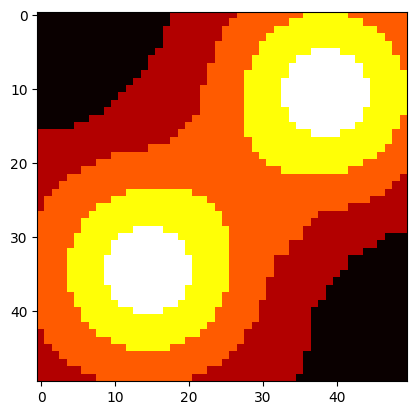

In [208]:
plt.imshow(sugar_distribution, cmap='hot', interpolation='nearest')

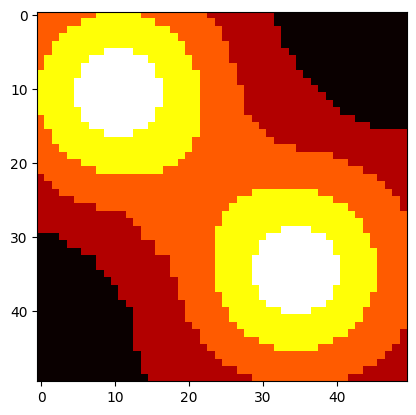

In [209]:
plt.imshow(spice_distribution, cmap='hot', interpolation='nearest')

# 7. Analysing the data

In [210]:
results = model.datacollector.get_model_vars_dataframe()

In [211]:
results

,Trader,Trade Volume,Price
0,200,738,0.971578
1,200,206,1.087645
2,200,138,1.057293
3,200,159,0.912008
4,200,42,0.897065
...,...,...,...
995,67,8,1.227035
996,67,9,1.300298
997,67,10,1.332138
998,67,7,1.364326


<AxesSubplot: >

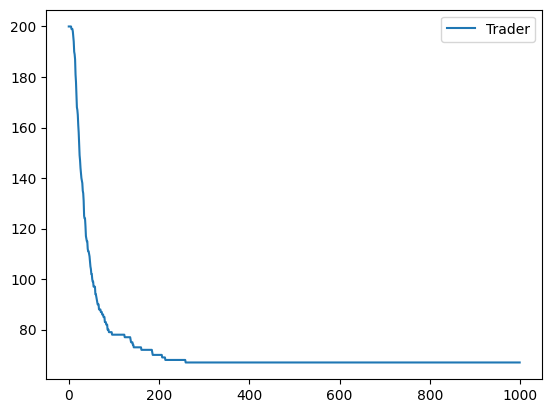

In [212]:
# Number of traders over time

results.plot(y= "Trader", use_index=True)

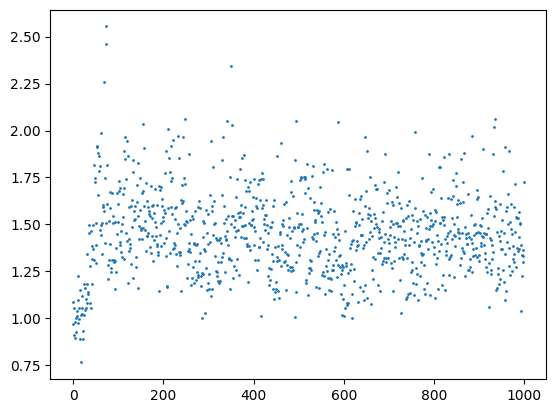

In [213]:
y = list(results['Price'])
x = range(1000)

plt.scatter(x, y, s=1)

<BarContainer object of 1000 artists>

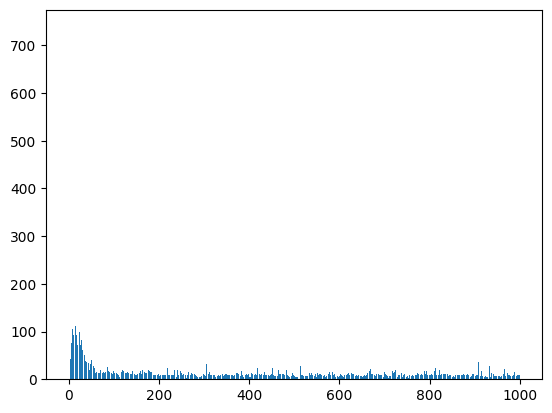

In [214]:
# Plot trade volume

plt.bar(results.index, results['Trade Volume'])

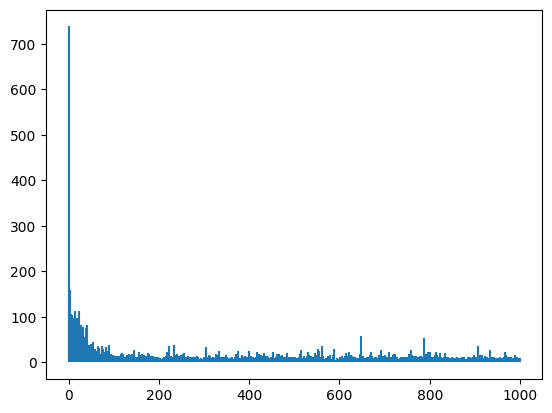

In [222]:
for i in range(1000):
    plt.vlines(i,0,results['Trade Volume'][i])

In [220]:
agent_results = model.datacollector.get_agent_vars_dataframe()
# filter out nones
agent_results = agent_results[agent_results["Trade Network"].notnull()]

In [221]:
agent_results

Trade Network
Step AgentID                                                   
1    4138                              [4262, 4262, 4262, 4262]
     4139     [4178, 4178, 4178, 4178, 4178, 4178, 4178, 417...
     4140                                                    []
     4141                                                    []
     4142                  [4163, 4163, 4163, 4163, 4163, 4163]
...                                                         ...
1000 4319                                                    []
     4326                                                    []
     4327                                                    []
     4329                                                    []
     4331                                                    []

[73127 rows x 1 columns]

In [234]:
# Create graph object
G = nx.Graph()

# Add agents to graph objects
G.add_nodes_from(list(model.schedule.agents_by_type[Trader].keys()))

In [235]:
for idx, row in agent_results.iterrows():
    if len(row['Trade Network']) > 0:
        for agent in row['Trade Network']:
            G.add_edge(idx[1], agent)

In [236]:
nx.node_connectivity(G), nx.average_clustering(G), nx.diameter(G), nx.global_efficiency(G)

(1, 0.41665532355468216, 4, 0.5317561034565959)

(array([41., 49., 23., 12., 12.,  9., 14., 14., 16.,  7.]),
 array([ 1. ,  8.8, 16.6, 24.4, 32.2, 40. , 47.8, 55.6, 63.4, 71.2, 79. ]),
 <BarContainer object of 10 artists>)

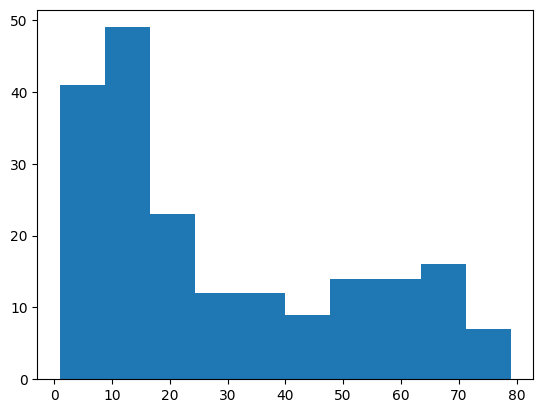

In [238]:
degree = [d for n,d in G.degree()]
plt.hist(degree)

# heavy trail degree distribution


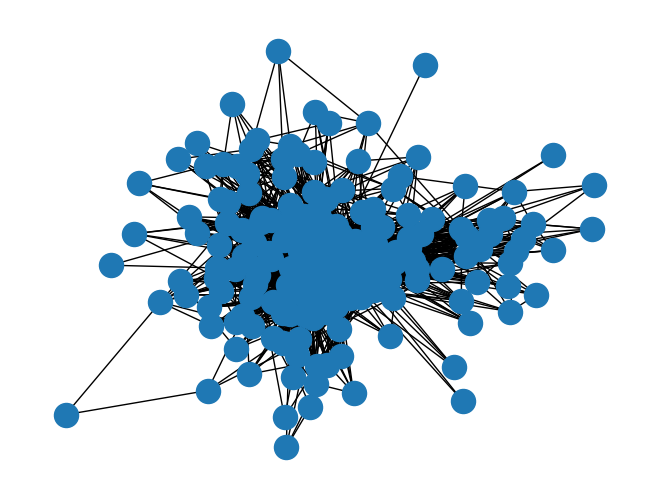

In [239]:
nx.draw(G)